In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

### Dataset and DataLoader

In [2]:
import torch
torch.manual_seed(seed=42)
import torchvision

transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.Pad(padding=2),
    torchvision.transforms.ToTensor()
])

ds_train = torchvision.datasets.FashionMNIST(root='data', download=True, train=True,
    transform=transform)
dl_train = torch.utils.data.DataLoader(dataset=ds_train, shuffle=True, batch_size=64)

ds_test = torchvision.datasets.FashionMNIST(root='data', download=True, train=False,
    transform=transform)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, shuffle=False, batch_size=16)

X shape: torch.Size([16, 1, 32, 32]), y shape: torch.Size([16])


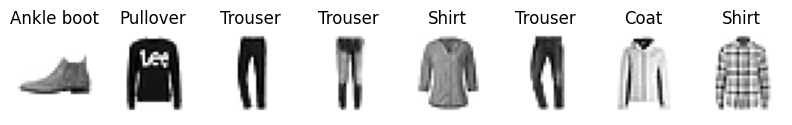

In [3]:
import matplotlib.pyplot as plt

idx_to_class = {v: k for k, v in ds_train.class_to_idx.items()}
X, y = next(iter(dl_test))
print(f"X shape: {X.shape}, y shape: {y.shape}")

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=[8, 2])
for j in range(len(axes)):
    image = X[j].squeeze()
    label = idx_to_class[y[j].item()]
    axes[j].imshow(X=image, cmap='binary')
    axes[j].set_title(label=f"{label}")
    axes[j].axis('off')
fig.tight_layout()
fig.show()

### Model

In [4]:
import torch
torch.manual_seed(seed=42)

class Sampling(torch.nn.Module):
    """
    This class will be used in the encoder for sampling in the latent space
    """
    def forward(self, z_mean, z_log_var):
        # get the shape of the tensor for the mean and log variance
        batch, dim = z_mean.shape
        # define a normal distribution of epsilon
        epsilon_dist = torch.distributions.normal.Normal(loc=0., scale=1.)
        # generate a normal random tensor (epsilon) with the same shape as z_mean
        epsilon = epsilon_dist.sample(sample_shape=(batch, dim)).to(z_mean.device)
        # apply the reparameterization trick to generate the samples in the latent space
        return z_mean + torch.exp(input=0.5*z_log_var)*epsilon

In [5]:
import torch
torch.manual_seed(seed=42)

class ConvBlock(torch.nn.Module):
    """
    Apply convolution layers with relu activation function
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                kernel_size=(3, 3), padding=(1, 1), stride=(2, 2)),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class Encoder(torch.nn.Module):
    """
    Define the Encoder. Pass the input through the encoder to get the latent vector.
    """
    def __init__(self, image_size=(32, 32), embedding_dim=2):
        super().__init__()
        # define the convolutional layers for downsampling and feature extraction
        self.features = torch.nn.Sequential(
            ConvBlock(in_channels=1, out_channels=32),
            ConvBlock(in_channels=32, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128)
        )
        # define a flatten layer
        self.flatten = torch.nn.Flatten()
        # define fully connected layers to transform the tensor into the embedding
        # dimensions
        feature_dim = (128, image_size[0]//(2**3), image_size[1]//(2**3))
        self.fc_mean = torch.nn.Linear(out_features=embedding_dim,
            in_features=feature_dim[0]*feature_dim[1]*feature_dim[2])
        self.fc_log_var = torch.nn.Linear(out_features=embedding_dim,
            in_features=feature_dim[0]*feature_dim[1]*feature_dim[2])
        # initialize the sampling layer
        self.sampling = Sampling()
        
    def forward(self, x):
        x = self.features(x)
        # flatten the tensor
        x = self.flatten(x)
        # get the mean and log variance of the latent space distribution
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        # sample a latent vector using the reparameterization trick
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

In [6]:
import torch
torch.manual_seed(seed=42)

class ConvTransposeBlock(torch.nn.Module):
    """
    Apply transposed convolutional layers with relu activation function
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                kernel_size=(3, 3), padding=(1, 1), stride=(2, 2), output_padding=(1, 1)),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class Decoder(torch.nn.Module):
    """
    Define the Decoder. Pass the latent vector through the decoder to get the reconstructed
    image.
    """
    def __init__(self, image_size=(32, 32), embedding_dim=2):
        super().__init__()
        # define a fully connected layer to transform the latent vector back to the
        # shape before flattening
        feature_dim = (128, image_size[0]//(2**3), image_size[1]//(2**3))
        self.fc = torch.nn.Linear(in_features=embedding_dim,
            out_features=feature_dim[0]*feature_dim[1]*feature_dim[2])
        # define a reshape function to reshape the tensor back to its original shape
        self.reshape = lambda x: x.view(-1, *feature_dim)
        self.features = torch.nn.Sequential(
            ConvTransposeBlock(in_channels=128, out_channels=64),
            ConvTransposeBlock(in_channels=64, out_channels=32),
            # apply the final transposed convolutional layer with a sigmoid activation to
            # generate the final output
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(3, 3),
                padding=(1, 1), stride=(2, 2), output_padding=(1, 1)),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        # pass the latent vector through the fully connected layer
        x = self.fc(x)
        # reshape the tensor
        x = self.reshape(x)
        x = self.features(x)
        return x

In [8]:
import torch
torch.manual_seed(seed=42)

class VAE(torch.nn.Module):
    """
    Define the VAE class. Return the mean, log variance and the reconstructed image 
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        # Initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# instantiate the encoder and decoder models
encoder = Encoder().to(device)
decoder = Decoder().to(device)
# pass the encoder and decoder to VAE class
vae = VAE(encoder=encoder, decoder=decoder)
total_params = sum(p.numel() for p in vae.parameters())
print(f"Total model parameters: {total_params}")

z_mean, z_log_var, reconstruction = vae(x=X.to(device))
print(f"z_mean shape: {z_mean.shape}")
print(f"z_log_var shape: {z_log_var.shape}")
print(f"reconstruction shape: {reconstruction.shape}")

Total model parameters: 199557
z_mean shape: torch.Size([16, 2])
z_log_var shape: torch.Size([16, 2])
reconstruction shape: torch.Size([16, 1, 32, 32])


### Training

In [ ]:
def train_step(model, dl_train, loss_fn, optimizer, device):
    model.train()
    losses = []
    for x, y in dl_train:
        x, y = x.to(device), y.to(device)